# 1. Introduction



- Calculate offer conversion rates by demographic segments.
- Compare spending behaviors with and without offers.
- Develop a predictive model to estimate whether a customer will respond to an offer.
- Develop heuristics or rules for sending the optimal offer based on past behavior


## 2. Data Loading and Exploration

In [2]:
import pandas as pd
import json


In [3]:

# Load the portfolio, profile, and transcript data
def load_json_lines(file_path):
    with open(file_path, 'r') as file:
        return [json.loads(line.strip()) for line in file if line.strip()]

# Define file paths
portfolio_path = 'data/portfolio.json'
profile_path = 'data/profile.json'
transcript_path = 'data/transcript.json'


## Data Preprocessing

In [15]:
def preprocess_data(portfolio_path, profile_path, transcript_path):
    """
    Preprocess data by loading the datasets and merging them.
    
    Args:
        portfolio_path (str): Path to the portfolio JSON file.
        profile_path (str): Path to the profile JSON file.
        transcript_path (str): Path to the transcript JSON file.
    
    Returns:
        pd.DataFrame: Merged dataframe containing all the data.
    """
    # Load the data
    portfolio_data = load_json_lines(portfolio_path)
    profile_data = load_json_lines(profile_path)
    transcript_data = load_json_lines(transcript_path)

    # Convert to DataFrames
    portfolio_df = pd.DataFrame(portfolio_data)
    profile_df = pd.DataFrame(profile_data)
    transcript_df = pd.DataFrame(transcript_data)

    # Merge the profile data with the transcript data on customer id
    merged_data = pd.merge(transcript_df, profile_df, left_on='person', right_on='id', how='left')

    # Filter for offer-related events
    offer_data = merged_data[merged_data['event'].isin(['offer received', 'offer completed'])]

    # Handle missing values
    offer_data['income'] = offer_data['income'].fillna(offer_data['income'].median())  # Fill missing income with median

    # Add a column indicating if an offer was completed
    offer_data['offer_completed'] = offer_data['event'] == 'offer completed'

    return offer_data, portfolio_df

In [17]:
# Preprocess the data (load and clean)
offer_data, portfolio_df = preprocess_data(portfolio_path, profile_path, transcript_path)

C:\Users\manys001\AppData\Local\Temp\ipykernel_37712\1387752602.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_data['income'] = offer_data['income'].fillna(offer_data['income'].median())  # Fill missing income with median
C:\Users\manys001\AppData\Local\Temp\ipykernel_37712\1387752602.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_data['offer_completed'] = offer_data['event'] == 'offer completed'


## 3. Exploratory Data Analysis


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def perform_eda(offer_data):
    """
    Perform exploratory data analysis on the offer data.
    
    Args:
        offer_data (pd.DataFrame): The preprocessed data.
    
    Returns:
        None
    """
    # 1. Basic statistics for numerical variables
    print("Basic Statistics:")
    print(offer_data.describe())
    
    # 2. Check for missing values
    print("\nMissing Values:")
    print(offer_data.isnull().sum())
    
    # 3. Distribution of categorical variables (gender, offer_completed)
    plt.figure(figsize=(12, 6))
    sns.countplot(x='gender', data=offer_data)
    plt.title('Gender Distribution')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.countplot(x='offer_completed', data=offer_data)
    plt.title('Offer Completion Distribution')
    plt.show()

    # 4. Relationship between age and income
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='age', y='income', data=offer_data, hue='offer_completed')
    plt.title('Age vs Income (Colored by Offer Completion)')
    plt.show()

    # 5. Distribution of income
    plt.figure(figsize=(12, 6))
    sns.histplot(offer_data['income'], kde=True)
    plt.title('Income Distribution')
    plt.show()

    # 6. Offer completion rate by age and income (heatmap)
    plt.figure(figsize=(12, 6))
    offer_data_grouped = offer_data.groupby(['age', 'income']).agg({'offer_completed': 'mean'}).reset_index()
    pivot_data = offer_data_grouped.pivot('age', 'income', 'offer_completed')
    sns.heatmap(pivot_data, cmap='coolwarm', annot=True)
    plt.title('Offer Completion Rate by Age and Income')
    plt.show()



Basic Statistics:
                time            age         income
count  109856.000000  109856.000000  109856.000000
mean      353.509321      61.119529   66533.516604
std       197.765495      24.976503   20601.205170
min         0.000000      18.000000   30000.000000
25%       168.000000      45.000000   52000.000000
50%       408.000000      58.000000   65000.000000
75%       504.000000      71.000000   79000.000000
max       714.000000     118.000000  120000.000000

Missing Values:
person                  0
event                   0
value                   0
time                    0
gender              10911
age                     0
id                      0
became_member_on        0
income                  0
offer_completed         0
dtype: int64


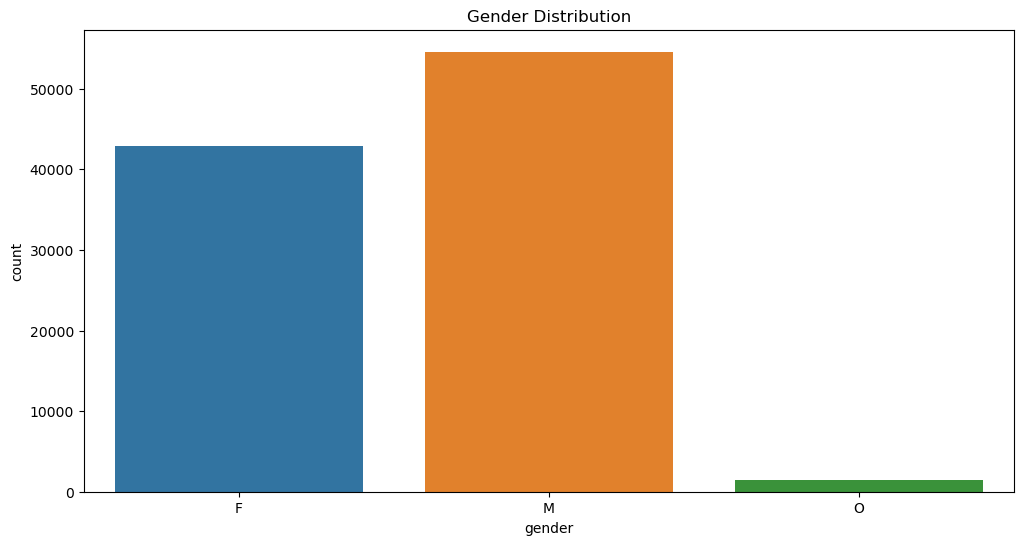

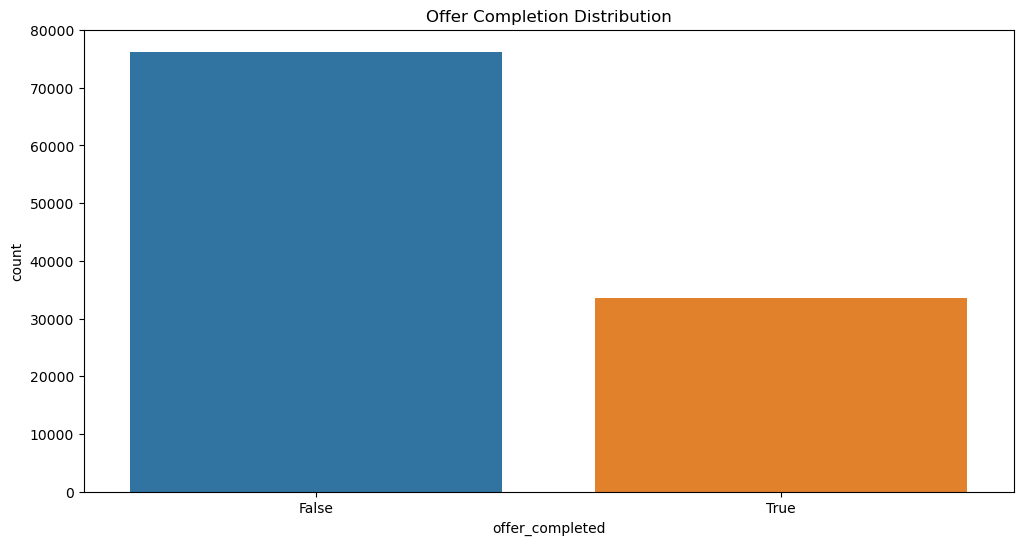

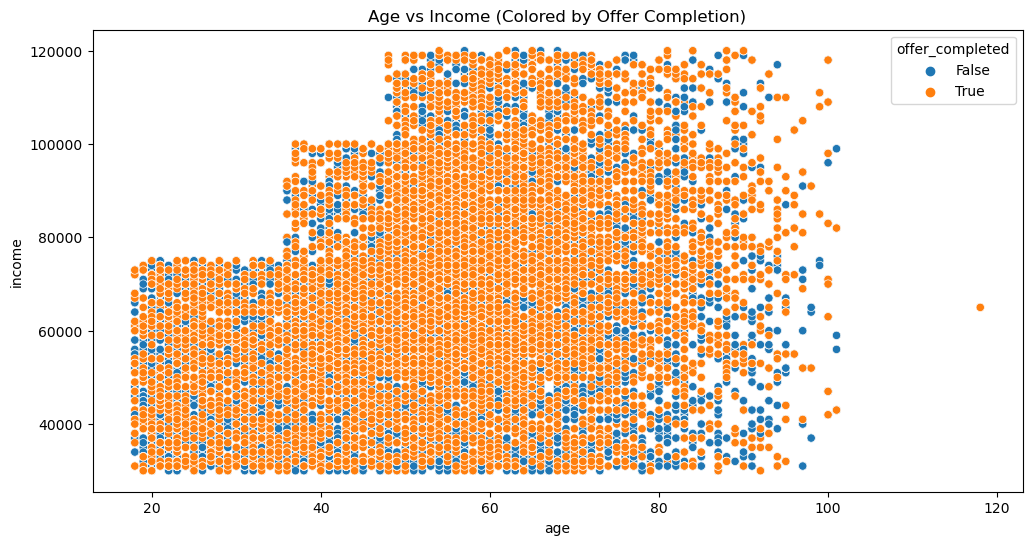

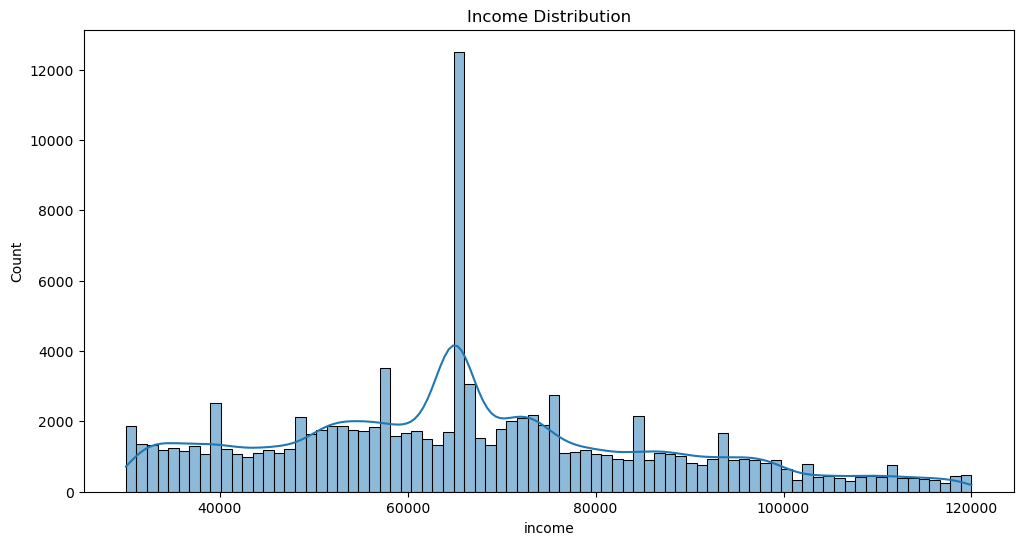

C:\Users\manys001\AppData\Local\Temp\ipykernel_37712\3017141323.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_data = offer_data_grouped.pivot('age', 'income', 'offer_completed')


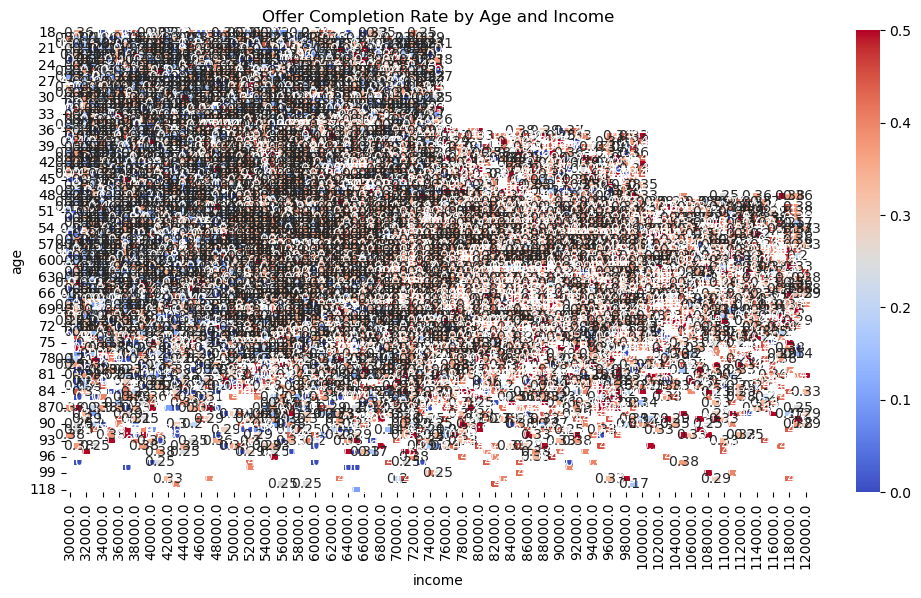

In [18]:
# Perform EDA on the preprocessed data
perform_eda(offer_data)

## 3. Model Implementation

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

def train_and_evaluate_models(X, y):
    """
    Train and evaluate multiple models (Random Forest and Logistic Regression).
    
    Args:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target vector (whether the offer was completed or not).
    
    Returns:
        dict: Dictionary containing classification reports for each model.
    """
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize models
    models = {
        'Random Forest': RandomForestClassifier(),
        'Logistic Regression': LogisticRegression(max_iter=1000)
    }

    results = {}

    # Train and evaluate each model
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        results[model_name] = report

    return results


In [21]:
# Prepare data for modeling (features and target variable)
X = offer_data[['age', 'income']]  # Features
y = offer_data['offer_completed']  # Target variable

# Train and evaluate models
results = train_and_evaluate_models(X, y)


c:\Users\manys001\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manys001\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manys001\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:

# Display the results
print("Model Comparison Results:")
for model_name, report in results.items():
    print(f"\n{model_name} Classification Report:")
    report = classification_report(y_test, y_pred)
    print(report)

Model Comparison Results:

Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.69      0.94      0.80     22980
        True       0.21      0.04      0.06      9977

    accuracy                           0.66     32957
   macro avg       0.45      0.49      0.43     32957
weighted avg       0.55      0.66      0.57     32957


Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.69      0.94      0.80     22980
        True       0.21      0.04      0.06      9977

    accuracy                           0.66     32957
   macro avg       0.45      0.49      0.43     32957
weighted avg       0.55      0.66      0.57     32957



## Results Analysis

Using the Classification report output to interpret and compare the models based on their performance.

**1. Interpret Precision and Recall:**
- For the **"True"** class (offer completed), we see that:
    - Precision is quite low, indicating that the model is often incorrect when predicting offer completion.
    - Recall is very low, suggesting that the model is failing to identify many instances where offers were completed.
    - This might be due to the class imbalance in the data, where the majority of the customers do not complete offers.

- For the **"False"** class (offer not completed), the precision and recall are higher, meaning the model is performing better at predicting when an offer was not completed.

## Handling the Class Imbalance

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

def handle_class_imbalance_and_tune_model(X, y):
    """
    Handle class imbalance by using class weights and perform hyperparameter tuning.
    
    Args:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target vector.
    
    Returns:
        RandomForestClassifier: Best tuned Random Forest model.
        dict: Classification report with performance metrics.
    """
    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=[0, 1], y=y)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    # Random Forest model with class weights
    rf_model = RandomForestClassifier(class_weight=class_weight_dict, random_state=42)

    # Define the hyperparameters to tune
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    # GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    
    # Fit GridSearchCV
    grid_search.fit(X, y)

    # Get the best model
    best_rf_model = grid_search.best_estimator_

    # Evaluate the best model
    y_pred = best_rf_model.predict(X)
    report = classification_report(y, y_pred, output_dict=True)

    return best_rf_model, report


In [25]:
# Step 1: Preprocess the data
offer_data, portfolio_df = preprocess_data(portfolio_path, profile_path, transcript_path)

# Step 2: Prepare the feature matrix (X) and target variable (y)
X = offer_data[['age', 'income']]  # Features
y = offer_data['offer_completed']  # Target variable

# Step 3: Handle class imbalance and perform hyperparameter tuning
best_rf_model, report = handle_class_imbalance_and_tune_model(X, y)

# Step 4: Display the results
print("Best Random Forest Model:", best_rf_model)
print("\nClassification Report:")
print(report)

C:\Users\manys001\AppData\Local\Temp\ipykernel_37712\1387752602.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_data['income'] = offer_data['income'].fillna(offer_data['income'].median())  # Fill missing income with median
C:\Users\manys001\AppData\Local\Temp\ipykernel_37712\1387752602.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_data['offer_completed'] = offer_data['event'] == 'offer completed'


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\manys001\AppData\Local\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Random Forest Model: RandomForestClassifier(class_weight={0: 0.7201122225572584,
                                     1: 1.6357842699306113},
                       max_features='auto', min_samples_leaf=4,
                       random_state=42)

Classification Report:
{'False': {'precision': 0.7956531573211605, 'recall': 0.5072957772329798, 'f1-score': 0.6195660875830598, 'support': 76277}, 'True': {'precision': 0.3861457295460856, 'recall': 0.7040412162363382, 'f1-score': 0.49874475222041725, 'support': 33579}, 'accuracy': 0.5674337314302359, 'macro avg': {'precision': 0.590899443433623, 'recall': 0.6056684967346591, 'f1-score': 0.5591554199017386, 'support': 109856}, 'weighted avg': {'precision': 0.670481569813339, 'recall': 0.5674337314302359, 'f1-score': 0.582635381748675, 'support': 109856}}


In [26]:
report = report
print(report)

{'False': {'precision': 0.7956531573211605, 'recall': 0.5072957772329798, 'f1-score': 0.6195660875830598, 'support': 76277}, 'True': {'precision': 0.3861457295460856, 'recall': 0.7040412162363382, 'f1-score': 0.49874475222041725, 'support': 33579}, 'accuracy': 0.5674337314302359, 'macro avg': {'precision': 0.590899443433623, 'recall': 0.6056684967346591, 'f1-score': 0.5591554199017386, 'support': 109856}, 'weighted avg': {'precision': 0.670481569813339, 'recall': 0.5674337314302359, 'f1-score': 0.582635381748675, 'support': 109856}}


### Key Takeaways:
- The model is better at predicting when an offer is not completed rather than when it is.
- While the recall for "True" offers is relatively high, precision remains low, meaning the model frequently misidentifies completions.
- The accuracy of 57% suggests there is significant room for improvement, particularly in detecting offer completions.
- Future improvements could focus on addressing this class imbalance further, using techniques like oversampling, undersampling, or experimenting with more advanced models (e.g., XGBoost, Gradient Boosting).

### Business Implications:
- The business could use the model to better understand which customers are likely to not complete offers, which could help in refining targeting strategies.
- For offer completions, additional steps are needed to improve prediction accuracy. Models with better recall for the "True" class should be prioritized to ensure more customers who are likely to respond to offers are identified.

In **conclusion**, while the current model provides some insights, it requires further refinement to improve its predictive power, especially for identifying offer completions.